In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Initialization
%run 'ML.ipynb'
ml = ML()
kf = KFold(n_splits=10, shuffle=True)
# plotting
plt.ioff()
sns.set_style("white")
df_cv = pd.DataFrame()
df_test = pd.DataFrame()
df_llov = pd.DataFrame()

# output
fh = open('output/model_eval.txt', 'a')
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), file=fh)

In [3]:
# Input files for each model

# Model 1
m1_params_fl = 'input/model1_params.txt'
m1_train_fl = 'input/model1_datasets/model1_train.xlsx'
m1_test_fl = 'input/model1_datasets/model1_test.xlsx'
m1_llov_fl = 'input/model1_datasets/model1_llov.xlsx'
# Model 2
m2_params_fl = 'input/model2_params.txt'
m2_train_fl = 'input/model2_datasets/model2_train.xlsx'
m2_test_fl = 'input/model2_datasets/model2_test.xlsx'
m2_llov_fl = 'input/model2_datasets/model2_llov.xlsx'
model_ls = ['Model 1', 'Model 2']

In [4]:

def model_details(mdl):
    if (mdl == 'Model 1'):
        return (m1_params_fl, m1_train_fl, m1_test_fl, m1_llov_fl)
    elif (model == 'Model 2'):
        return (m2_params_fl, m2_train_fl, m2_test_fl, m2_llov_fl)

def combine_predictions(df1):
    for indx, row in df1.iterrows():
        val1 = row['Model 1 Predicted']
        val2 = row['Model 2 Predicted']
        df1.at[indx, 'Combined Predicted'] = (val1 + val2)/2
    return(df1)

In [5]:
fig_ls = []
for model in model_ls:
    if model == 'Model 2':
        print("#################")
        print("#", file = fh)
        
    m_params_fl, m_train_fl, m_test_fl, m_llov_fl = model_details(model)

    # Load RF with params (not trained)
    rf = ml.load_ml_params(m_params_fl)
    
    # Load dataset
    X_train, y_train, z_train = ml.load_dataset(m_train_fl)
    X_test, y_test, z_test = ml.load_dataset(m_test_fl)
    X_llov, y_llov, z_llov = ml.load_dataset(m_llov_fl)
    
    # 10-fold CV:
    y_train_pred = cross_val_predict(rf, X_train, y_train, cv=kf)
    r2_cv = r2_score(y_train, y_train_pred)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=kf, verbose=0, scoring='r2')
    s = f'{model} R2 (CV)\t{r2_cv:.2f} | {cv_scores.mean():0.2f} +/- {cv_scores.std():0.2f}'
    print(s)
    print('\t' + s, file=fh)
    # Storing CV predictions on a DataFrame
    for l,p in zip(y_train.index, y_train_pred):
        df_cv.at[l, f'Observed'] = y_train[l]
        df_cv.at[l, f'{model} Predicted'] = p
    # Plot CV
    xy_cv = plt.figure(figsize=(5,5))
    xy_cv = ml.plot_obs_pred2(y_train, y_train_pred, f'{model} 10-Fold CV', 400, True, xy_cv)
    fig_ls.append(xy_cv)    
    
    # train RF on the entire training dataset
    rf.fit(X_train, y_train)

    # test
    y_test_pred = rf.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    s = f'{model} R2 (test)\t{r2_test:.2f}'
    print(s)
    print('\t' + s, file = fh)
    # Storing test predictions on a DataFrame
    for l,p in zip(y_test.index, y_test_pred):
        df_test.at[l, f'Observed'] = y_test[l]
        df_test.at[l, f'{model} Predicted'] = p
    # Plot test
    xy_test = plt.figure(figsize=(5,5))
    xy_test = ml.plot_obs_pred2(y_test, y_test_pred, f'{model} Test', 400, True, xy_test)
    fig_ls.append(xy_test)
    
    # llov test
    y_llov_pred = rf.predict(X_llov)
    r2_llov = r2_score(y_llov, y_llov_pred)
    s = f'{model} R2 (LLOV)\t{r2_llov:.2f}'
    print(s)
    print('\t' + s, file = fh)
    # Storing test predictions on a DataFrame
    for l,p in zip(y_llov.index, y_llov_pred):
        df_llov.at[l, f'Observed'] = y_llov[l]
        df_llov.at[l, f'{model} Predicted'] = p
    # plot llov
    xy_llov = plt.figure(figsize=(5,5))
    xy_llov = ml.plot_obs_pred2(y_llov, y_llov_pred, f'{model} LLOV',400, True, xy_llov)   
    fig_ls.append(xy_llov)

Model 1 R2 (CV)	0.74 | 0.72 +/- 0.07
Model 1 R2 (test)	0.71
Model 1 R2 (LLOV)	0.68
#################
Model 2 R2 (CV)	0.75 | 0.74 +/- 0.07
Model 2 R2 (test)	0.76
Model 2 R2 (LLOV)	0.59


In [6]:
print("#", file = fh)
# Combine crossvalidation predictions
df_cv = combine_predictions(df_cv)
r2_cv_comb = r2_score(df_cv['Observed'], df_cv['Combined Predicted'])
s = f'Combined model R2 (CV)\t{r2_cv_comb:.2f}'
print(s)
print('\t' + s, file = fh)
xy_cv = plt.figure(figsize=(5,5))
xy_cv = ml.plot_obs_pred2(df_cv['Observed'], df_cv['Combined Predicted'], \
                            f'Combined CV',400, True, xy_cv) 
fig_ls.append(xy_cv)

# Combine test predictions
df_test = combine_predictions(df_test)
r2_test_comb = r2_score(df_test['Observed'], df_test['Combined Predicted'])
s = f'Combined model R2 (test)\t{r2_test_comb:.2f}'
print(s)
print('\t' + s, file = fh)
xy_test = plt.figure(figsize=(5,5))
xy_test = ml.plot_obs_pred2(df_test['Observed'], df_test['Combined Predicted'], \
                            f'Combined Test',400, True, xy_test)   
fig_ls.append(xy_test)

# Combine LLOV predictions
df_llov = combine_predictions(df_llov)
r2_llov_comb = r2_score(df_llov['Observed'], df_llov['Combined Predicted'])
s = f'Combined model R2 (LLOV)\t{r2_llov_comb:.2f}'
print(s)
print('\t' + s, file = fh)
print("###################################################", file = fh)
xy_llov = plt.figure(figsize=(5,5))
xy_llov = ml.plot_obs_pred2(df_llov['Observed'], df_llov['Combined Predicted'], \
                            f'Combined LLOV',400, True, xy_llov)   
fig_ls.append(xy_llov)
fh.close()

Combined model R2 (CV)	0.76
Combined model R2 (test)	0.75
Combined model R2 (LLOV)	0.67


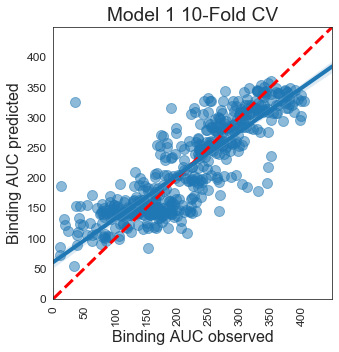

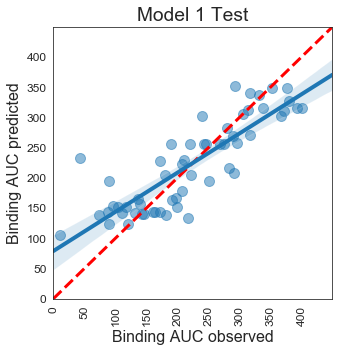

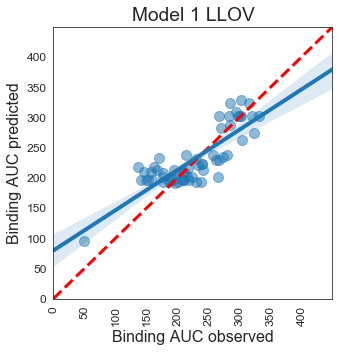

In [7]:
# Model 1 plots
display(fig_ls[0])
display(fig_ls[1])
display(fig_ls[2])

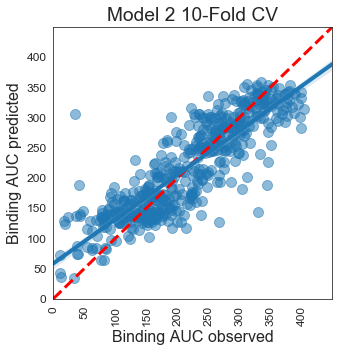

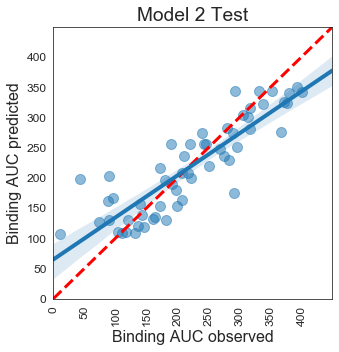

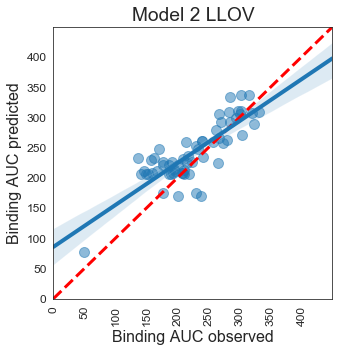

In [8]:
# Model 2 plots
display(fig_ls[3])
display(fig_ls[4])
display(fig_ls[5])

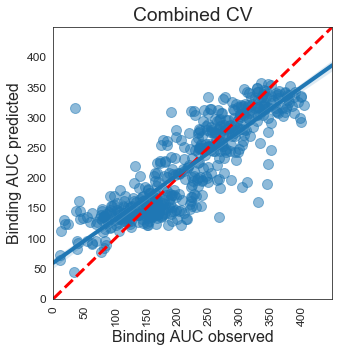

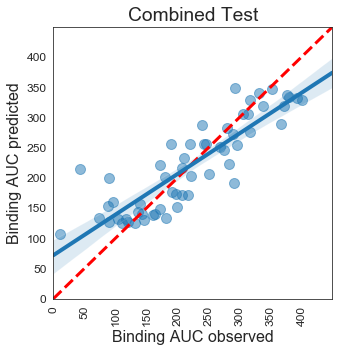

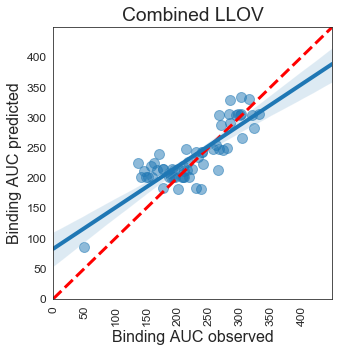

In [9]:
# Combined model plots
display(fig_ls[6])
display(fig_ls[7])
display(fig_ls[8])